In [23]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 

In [24]:
class market_position(object):
    def __init__(self, sigma, ell, v=0.01):
        '''Initialize the simulator, v is the spread, we assume it is constant for now.'''

        # constant parameters
        self.sigma = sigma
        self.ell = ell
        self.dt = 1
        self.spread = v
        self.transaction_p = 0.7
        self.inventory_limit = 100
        self.reverse_selection_factor = 0.0001

        # list to contain historical movements of variables
        self.value = 10000
        self.x = 10
        self.bid = 9.75
        self.ask = 10.25
        self.q = 0
        self.cash = 10000
        #initial_skew = findMaxSkew(self.mu, self.sigma, self.x[-1], self.ell, self.cash[-1], self.q[-1], self.spread, self.dt)
        initial_skew = 0.5
        self.skew = initial_skew
        self.Pbuy = initial_skew

    def __repr__(self):
        '''Representation'''
        result = ""
        result += "Final stock price is: " + str(self.x) + "\n"
        result += "Final inventory is: " + str(self.q) + "\n"
        result += "Final cash account is: " + str(self.cash) + "\n"
        result += "Final P&L is: " + str(self.value - 10000)
        return result
    
    def set_skew(self, skew):
        '''Set a new skewness of bid ask spread'''
        self.skew = skew

    def get_accumulated_value(self, t):
        '''Show hist P&L'''
        return self.value
    
    def transaction_coming(self):
        '''Return True as a transaction has arrived, return False as no transaction coming.'''
        return np.random.binomial(1, self.transaction_p) == 1
    
    def buy_sell(self):
        '''Return True as buy transaction, return False as sell transaction'''
        return np.random.binomial(1, self.Pbuy) == 1
    
    def new_stock_price(self):
        '''Return stock price change as a geometric brownian motion'''
        return self.x * math.exp((-1 * (self.sigma ** 2) / 2) * self.dt + self.sigma * np.random.normal() * math.sqrt(self.dt))
    
    def simulate_one_3tree(self):
        '''Simulate one time foreward. This method simulated stock price in 3 branches tree'''
        # simulate incoming transaction, if there is, adjust inventory and cash account
        transaction = self.transaction_coming()
        buy = self.buy_sell()
        if self.transaction_coming() and buy and self.q <= self.inventory_limit:
            self.q = self.q + 1
            self.cash = self.cash - self.bid
            self.x = self.x * (1 - self.reverse_selection_factor)
        elif self.transaction_coming() and (not buy) and self.q >= (-1 * self.inventory_limit):
            self.q = self.q - 1
            self.cash = self.cash + self.ask
            self.x = self.x * (1 + self.reverse_selection_factor)

        self.x = self.new_stock_price()
        
        self.value = self.q * self.x + self.cash
        
        new_skew = findMaxSkew(self.sigma, self.x, self.ell, self.cash, self.q, self.spread, self.dt)
        self.skew = new_skew
        self.Pbuy = self.skew
        self.ask = self.x + self.spread * (3 / 2 - 2 * self.skew)
        self.bid = self.x + self.spread * (1 / 2 - 2 * self.skew)
        
    def n_simulate(self, n):
        '''simulate n steps'''
        for i in range(n):
            self.simulate_one_3tree()
            if self.Pbuy < 0:
                break
            if self.value - 10000 < -1 * self.ell:
                break


In [25]:
def findMaxSkew(sigma,x,ell,cash,Q,vx,dt):
    return 0.5

[ -50.90423878  -50.69188988  -50.53227196  -50.52716102  -50.49299587
  -50.37172216  -50.29036514  -50.26579691  -50.23439959  -50.21569267
  -13.11031241    7.48229866    8.5590466     8.69147348    8.76222017
    9.37664046   18.6104428    24.27276862   27.32846955   28.61200451
   29.93990113   35.22714877   37.40253946   38.89403249   41.18192208
   42.56578066   51.24459629   56.91109958   65.91193674   68.2549469
   69.60265843   71.78237357   73.87960047   76.88641413   83.43322911
   91.33558152   92.33910837   95.52923291   97.67704025  107.34788282
  117.229027    117.67733618  140.48481919  142.39244195  142.48228603
  150.34031732  163.09780053  166.90287028  217.50726189  345.23035727]
Time used:  18.647104999999982


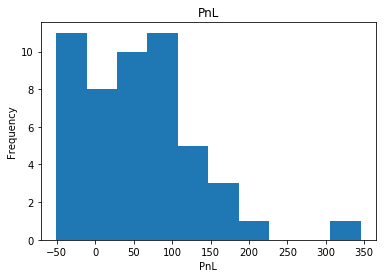

In [28]:
if __name__ == "__main__":
    tic = time.clock()
    result = []
    for i in range(50):
        market = market_position(0.001, 50)
        market.n_simulate(18000)
        
        result.append(market.value - 10000)
    toc = time.clock()
    
    print(np.array(sorted(result)))
    
    print('Time used: ', toc - tic)
    
    plt.hist(result)
    plt.title("PnL")
    plt.xlabel("PnL")
    plt.ylabel("Frequency")

    plt.show()